# A Robust Measure of Central Tendency in $N$ Dimensions
_Charles C. Kankelborg_

## Abstract
If the domain of some probability density function (PDF) is a Euclidean space with $N>1$ dimensions, then a meaningful measure of central tendency  should be uniquely derivable for any normalizable PDF on that space, and should be invariant under changes of coordinates. For this purpose, I propose an $N$-dimensional generalization of the median. The _generalized median_ is more robust than a centroid, is capable of sub-pixel precision, and can be computed quickly from a binned, $N$-dimensional histogram by FFT convolution. I have implemented the generalized median as a Python module for the special case of two dimensions, with an eye toward image processing. A few test cases are shown to illustrate the robustness of the method.


## The Median
We begin by describing the traditional median as follows:
$$
    x_m = \underset{x}{\arg \min} \,
        \int_{\mathcal{D}}  P(x')\, \left| x-x' \right| \,dx'
$$
where $\mathcal{D}$ is the support (domain) of the PDF $P(x)$. This is perhaps an atypical definition, but if you think about it you will realize that it is the median.

## The Generalized Median
By analogy to the previous section, we define the $N$-dimensional generalized median as follows:
$$
    \mathbf{r}_m = \underset{\mathbf{r}}{\arg \min} \,
        \int_{\mathcal{D}} P(\mathbf{r'})\,\left| \mathbf{r-r'} \right| \,d^N r'
        = \underset{\mathbf{r}}{\arg \min} \,\,P(\mathbf{r}) * \left|\mathbf{r}\right|.
$$


## Proposed Algorithm
By the following algorithm, the generalized median can run on an $N$-dimensional array in $\mathcal{O}\left(n\,\log n \right)$ time, where $n$ is the number of data points.
1. Begin with $P_{ij}$, a sampled array representation of $P(\mathbf{r})$.$^*$
1. Use FFT to convolve $P_{ij}$ with an array representation of the cone function, $\left| \mathbf{r} \right|$. Call the result $C_{ij}$, which of course represents a continuous function $C(\mathbf{r})$.
2. Find $(i_m,j_m)$, the index of the minimum entry in the array representation of $C(\mathbf{r})$. Its location is, to within the sampling interval, an approximation of $\mathbf{r}_m$.
3. Using a local neighborhood of perhaps $3^N$ pixels surrounding $(i_m,j_m)$, fit a quadratic form to $C_{ij}$ and minimize it to obtain a sub-pixel estimate of $\mathbf{r}_m$.

$^*$ I write just two indices because I am thinking about images, but in general my proposed algorithm can be implemented in $N$ dimensions.

## Calculations
Below, I perform some example calculations on test images using a Python module, `gm.py`. In addition to the generalized median $\mathbf{r}_m$, I employ a related measure of the width of the distribution, the mean absolute radius:
$$
    \text{mean absolute radius} = 
    \frac{
        \int_{\mathcal{D}} P(\mathbf{r'})\,\left| \mathbf{r}_m - \mathbf{r}' \right| \,d^N r'
    }{
        \int_{\mathcal{D}} P(\mathbf{r'})\,d^N r'
    }
$$
For comparison to the generalized median, I consider the centroid. For comparison to the mean absolute radius, I consider both the equivalent width and the RMS radius.

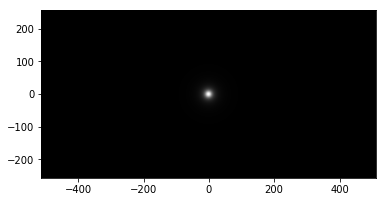

gm2d quadratic fit accounts for  99.9999823733884 % of 3x3 neighborhood variance
generalized median:  1.907843965490648e-13 -2.4910392067446473e-13
centroid:  3.5647405458753576e-16 -2.251415081605489e-16
equivalent radius: 19.017071110115342
mean abs radius:  56.75138084957386
RMS radius: 96.39281129969413


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gm

# Coordinates for test images
Nx = 512
Ny = 256
x = np.arange(-Nx,Nx+1)
y = np.arange(-Ny,Ny+1)
xs,ys = np.meshgrid(x,y)
rs = np.sqrt(xs**2 + ys**2)
# Specify correct extent for plt.imshow(... origin='lower')
extent = (x[0]-0.5,x[-1]+0.5,y[0]-0.5,y[-1]+0.5)

# Test image 1, precisely centered
test1 = 1./(1+(rs/10.)**2.5)
imgplot = plt.imshow(test1, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')
plt.show()
(jm1,im1,delta_x1,delta_y1,meanabsrad1) = gm.gm2d(test1)

print('generalized median: ',x[jm1]+delta_x1,y[im1]+delta_y1)

# Compare moments
xc1 = np.sum(xs*test1)/np.sum(test1)
yc1 = np.sum(ys*test1)/np.sum(test1)
print('centroid: ',xc1,yc1)
rmsrad1 = np.sqrt(  np.sum( ( ( xs-xc1)**2 + (ys-yc1)**2 ) * test1 ) / np.sum(test1)  )

# Measures of width:
equivrad1 = np.sqrt( np.sum(test1)/np.amax(test1)/np.pi )
print('equivalent radius:',equivrad1)
print('mean abs radius: ',meanabsrad1)
print('RMS radius:',rmsrad1)



true spot center:  -327 102
gm2d quadratic fit accounts for  99.99982174779316 % of 3x3 neighborhood variance
generalized median:  -326.36883237939605 101.38157023638097
centroid:  -318.0430991539659 95.5785331767498
equivalent radius: 18.747975030984097
mean abs radius:  52.13155926579982
RMS radius: 92.70242404066751


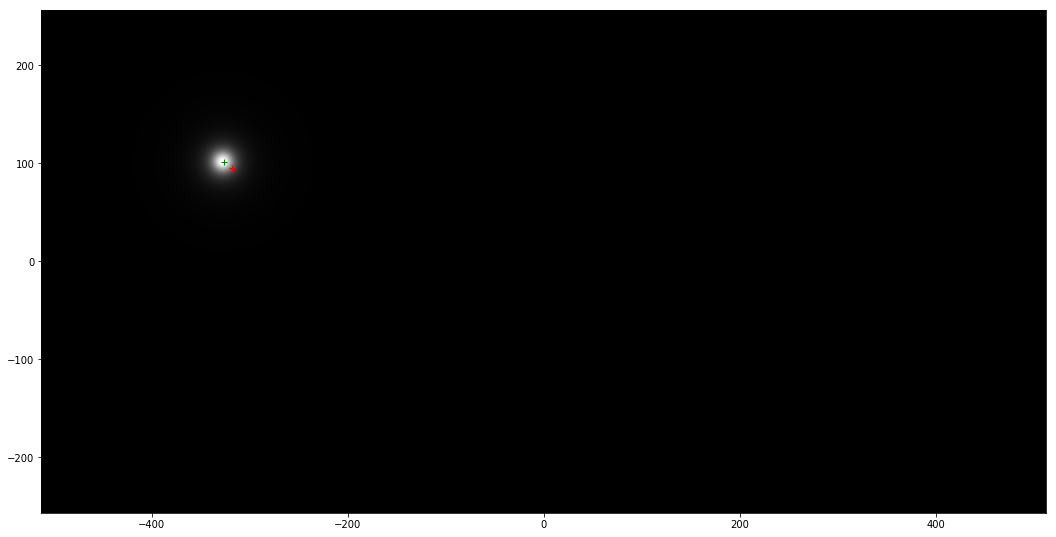

In [2]:
# Test image 2, strongly offset from center
xtrue = -327
ytrue = +102
rs2 = np.sqrt((xs-xtrue)**2 + (ys-ytrue)**2)
test2 = 1./(1+(rs2/10.)**2.5)

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test2, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# First, give the true center value
print('true spot center: ',xtrue,ytrue)

# Generalized median calculation
(jm2,im2,delta_x2,delta_y2,meanabsrad2) = gm.gm2d(test2)
xgm2 = x[jm2]+delta_x2
ygm2 = y[im2]+delta_y2
print('generalized median: ',xgm2,ygm2)

# Compare moments
xc2 = np.sum(xs*test2)/np.sum(test2)
yc2 = np.sum(ys*test2)/np.sum(test2)
print('centroid: ',xc2,yc2)
rmsrad2 = np.sqrt(  np.sum( ( ( xs-xc2)**2 + (ys-yc2)**2 ) * test2 ) / np.sum(test2)  )

# Measures of width:
equivrad2 = np.sqrt( np.sum(test2)/np.amax(test2)/np.pi )
print('equivalent radius:',equivrad2)
print('mean abs radius: ',meanabsrad2)
print('RMS radius:',rmsrad2)

# Overplot stats
plt.plot(xc2,yc2,'r+',xgm2,ygm2,'g+')
plt.show()

true cluster center:  -327 102
gm2d quadratic fit accounts for  99.99732494195709 % of 3x3 neighborhood variance
generalized median:  -325.3735924451872 100.36404127187268
centroid:  -317.924128435217 95.44021752805236
equivalent radius: 31.98265768873919
mean abs radius:  64.38640743637947
RMS radius: 97.19660533773553


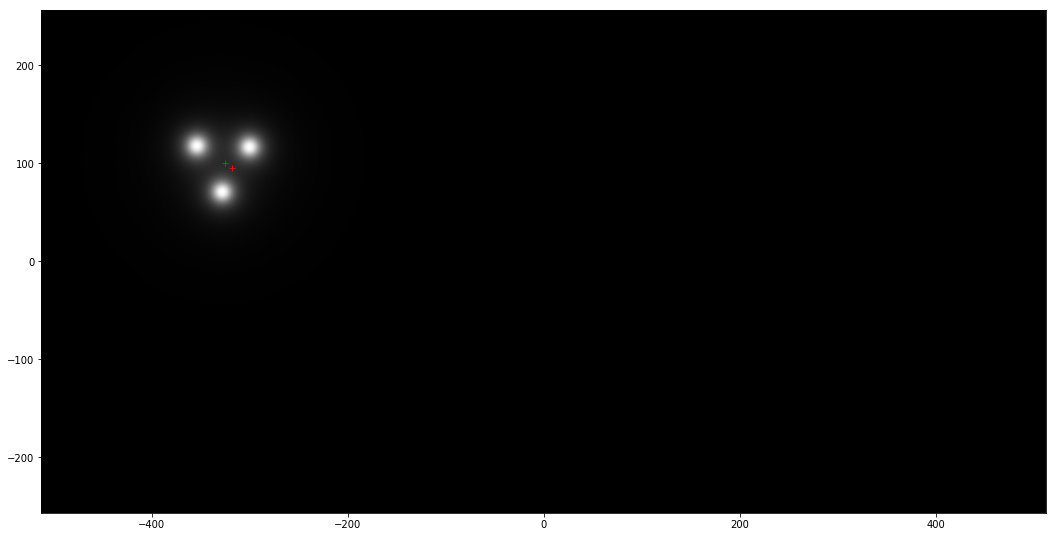

In [3]:
# Now test with three sources, arranged in an equilateral triangle.
test3 = test1*0. # start from a clean slate.
rsrc = 31.
thetasrc = np.array([0,1./3.,2./3.]) * 2.*np.pi + 0.5
xsrc = rsrc * np.cos(thetasrc) + xtrue
ysrc = rsrc * np.sin(thetasrc) + ytrue
for i in range(3):
    rs3 = np.sqrt((xs-xsrc[i])**2 + (ys-ysrc[i])**2)
    test3 = test3 + 1./(1+(rs3/10.)**2.5)

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test3, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# First, give the true center value
print('true cluster center: ',xtrue,ytrue)

# Generalized median calculation
(jm3,im3,delta_x3,delta_y3,meanabsrad3) = gm.gm2d(test3)
xgm3 = x[jm3]+delta_x3
ygm3 = y[im3]+delta_y3
print('generalized median: ',xgm3,ygm3)

# Compare moments
xc3 = np.sum(xs*test3)/np.sum(test3)
yc3 = np.sum(ys*test3)/np.sum(test3)
print('centroid: ',xc3,yc3)
rmsrad3 = np.sqrt(  np.sum( ( ( xs-xc3)**2 + (ys-yc3)**2 ) * test3 ) / np.sum(test3)  )

# Measures of width:
equivrad3 = np.sqrt( np.sum(test3)/np.amax(test3)/np.pi )
print('equivalent radius:',equivrad3)
print('mean abs radius: ',meanabsrad3)
print('RMS radius:',rmsrad3)

# Overplot stats
plt.plot(xc3,yc3,'r+',xgm3,ygm3,'g+')
plt.show()

min pixel value (counts):  -47.074515620653564
max pixel value (counts):  353.6855858702345
bias (counts):  -0.12621066260727384
true cluster center:  -327 102
gm2d quadratic fit accounts for  99.99391656843252 % of 3x3 neighborhood variance
generalized median:  -328.19496509972 101.8815830336158
centroid:  -338.4697968071594 102.47731656905805
equivalent radius: 28.87747965232512
mean abs radius:  41.08586351954166
RMS radius: nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


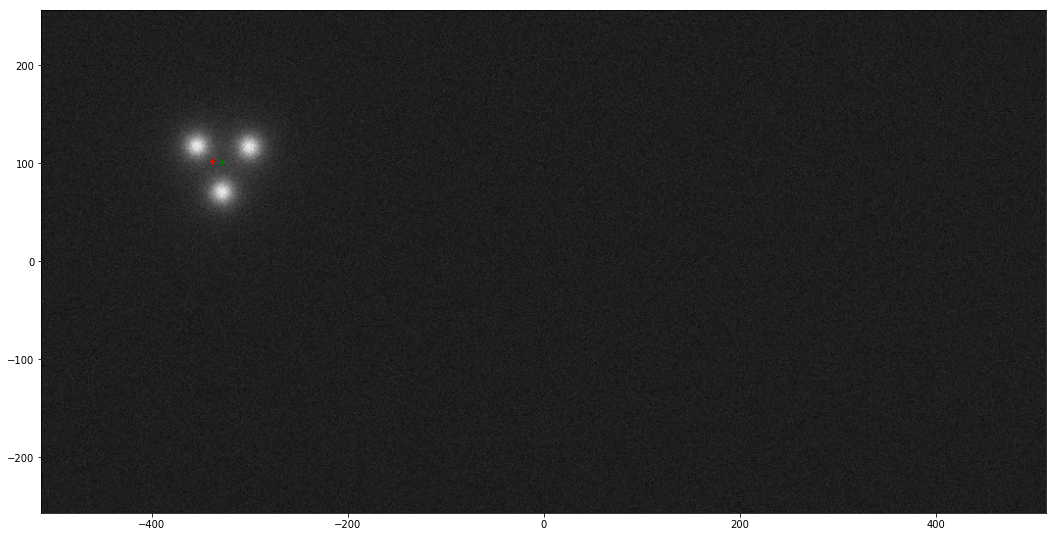

In [4]:
# Test with shot noise, read noise, and bias
counts = 3e2     # Approx max count rate
sigma_read = 10  # RMS read noise (counts; e.g. 10 counts = 10 electrons visible)
bias = 0.5*np.random.randn() # Uniform unsubtracted background
readnoise = sigma_read * np.random.standard_normal(test3.shape)
test4 = np.random.poisson(counts*test3, test3.shape) + readnoise + bias

fig=plt.figure(figsize=(18, 16))
imgplot = plt.imshow(test4, cmap='gray', extent=extent, 
                     aspect='equal', origin='lower',
                     interpolation='bilinear')

# Give the true center value, and some useful stats
print('min pixel value (counts): ', np.amin(test4))
print('max pixel value (counts): ', np.amax(test4))
print('bias (counts): ',bias)
print('true cluster center: ',xtrue,ytrue)

# Generalized median calculation
(jm4,im4,delta_x4,delta_y4,meanabsrad4) = gm.gm2d(test4)
xgm4 = x[jm4]+delta_x4
ygm4 = y[im4]+delta_y4
print('generalized median: ',xgm4,ygm4)

# Compare moments
xc4 = np.sum(xs*test4)/np.sum(test4)
yc4 = np.sum(ys*test4)/np.sum(test4)
print('centroid: ',xc4,yc4)
rmsrad4 = np.sqrt(  np.sum( ( ( xs-xc4)**2 + (ys-yc4)**2 ) * test4 ) / np.sum(test4)  )

# Measures of width:
equivrad4 = np.sqrt( np.sum(test4)/np.amax(test4)/np.pi )
print('equivalent radius:',equivrad4)
print('mean abs radius: ',meanabsrad4)
print('RMS radius:',rmsrad4)

# Overplot stats
plt.plot(xc4,yc4,'r+',xgm4,ygm4,'g+')
plt.show()



## Discussion
The example images used above are meant to mimic, and perhaps exaggerate, certain difficult features of spot images that may occur in an experiment to determine the best focus of an optical sytem. These include:
1. Broad tails. I have chosen the form $\left( 1 + r^{\frac{5}{2}} \right)^{-1}$, which is only barely integrable. Even the first moment in this case converges only because of the finite field of view, and therefore the first and second moments are ill-defined.
1. Off-center presentation. That is, the spot is not well centered in the field of view, and so the tails of the distribution (and any background) tend to draw any measure of central tendency away from the true center and toward the center of the frame.
1. Multi-modal spots. I have an equilateral triangle of identical spots, but real spots are more complicated due to diffraction effects. For this reason, I did not consider the mode as a potential measure of central tendency.
1. Noise, including shot noise and read noise. Consequently, the images can contain negative pixels.
1. Uncompensated bias. While we try to remove backgrounds such as pedestal, and dark current and diffuse backgrounds from our images, these backgrounds can be difficult to estimate and may fluctuate. Negative bias can contribute to the appearance of negative pixels in the PSF wings, resulting in failure to get a second moment. Positive bias inflates the PSF wings, drawing the centroid to the center.

The reader is encouraged to re-run the last calculation repeatedly, to see how different realizations of noise and bias affect the results. It would be even better to do a MonteCarlo test to get many realizations of noise and bias, but I think that the general characteristics of t

### Central Tendency

Throughout these experiments, the generalized median is a more consistent and reliable measure of central tendency than the centroid. Neither of these measures cares about multi-modal spots, but the generalized median is less susceptible to broad tails, off-center presentation, multi-modal spots, noise, and bias.

It is widely known that the centroid of a binned distribution (such as an image or spectrum) can be calculated to sub-pixel accuracy. These experiments show that the same is true of the generalized median. In `gm2d` I find the minimum of the convolution integral to sub-pixel accuracy by fitting a $3\times 3$ neighborhood to a quadratic function. Note the lines of output that say `gm2d quadratic fit accounts for  99.998... % of 3x3 neighborhood variance`. These show that the quadratic fit is an excellent description of the neighborhood around the minimum. Of course, in cases where the central tendency is greatly influenced by off-center presentation or other effects, sub-pixel precision should not be confused with sub-pixel accuracy!

### Width

The second moment, or RMS radius, computed naively as I have done, is almost useless since enough negative pixels will render it impossible to compute. It is also too sensitive to the distribution tails, bias, and random noise. However, the RMS radius is not very sensitive to off-center presentation. The mean absolute radius is somewhat more robust than the RMS radius, but still not very good. The equivalent width, or equivalent radius, is a very robust measure of spot width. It is far more consistent than my other two candidates.

I did not try trimming the distribution, that is restricting consideration to pixels with intensity greater than some minimum value, such as a fixed fraction of the maximum intensity. This simple fix could go a long way to making the moment-based measures more robust.

As a parting comment, I note that the equivalent width does have (at least) one significant flaw: its reliance on the distribution maximum. If the distribution peak is sharp on the scale of a pixel, this maximum could fluctuate from image to image due to noise and/or sampling effects. Provided that the diffraction limit (or other considerations) blur the peak sufficiently, the reliance on a single maximum pixel value will not prove to be a fatal flaw.